In [7]:
import math

import matplotlib as mpl
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import distributions as td

mpl.rcParams["text.usetex"] = True
mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")

In [8]:
xx = torch.linspace(-3, 3, 10000)

In [9]:
sigma_o = 0.1

tds = {
    "Gaussian": td.Normal(loc=0.0, scale=sigma_o),
    "Laplace": td.Laplace(loc=0.0, scale=sigma_o / math.sqrt(2)),
    "Uniform": td.Uniform(low=-math.sqrt(3) * sigma_o, high=math.sqrt(3) * sigma_o),
}
for s in [0.1, 0.2, 0.5, 1.0]:
    shift = -sigma_o / math.expm1(s**2) ** 0.5
    tds[f"LogNormal-{s}"] = td.LogNormal(
        loc=-(s**2) / 2 + math.log(-shift),
        scale=s,
    )

In [10]:
dfs = []

In [11]:
for k, dist in tds.items():
    if isinstance(dist, td.Uniform):
        mask = dist.support.check(xx)
        pdf = torch.zeros_like(xx)
        pdf[mask] = torch.exp(dist.log_prob(xx[mask]))
        xx_plot = xx
    elif isinstance(dist, td.LogNormal):
        mask = dist.support.check(xx)
        pdf = torch.zeros_like(xx)
        pdf[mask] = torch.exp(dist.log_prob(xx[mask]))
        xx_plot = xx - sigma_o / math.expm1(dist.scale**2) ** 0.5
    else:
        pdf = torch.exp(dist.log_prob(xx))
        xx_plot = xx
    dfs.append(pd.DataFrame({"x": xx_plot.numpy(), "pdf": pdf.numpy(), "distribution": k}))

df = pd.concat(dfs, ignore_index=True)
df

,x,pdf,distribution
0,-3.000000,0.000000,Gaussian
1,-2.999400,0.000000,Gaussian
2,-2.998800,0.000000,Gaussian
3,-2.998200,0.000000,Gaussian
4,-2.997600,0.000000,Gaussian
...,...,...,...
69995,2.921312,0.000022,LogNormal-1.0
69996,2.921912,0.000022,LogNormal-1.0
69997,2.922512,0.000022,LogNormal-1.0
69998,2.923112,0.000022,LogNormal-1.0


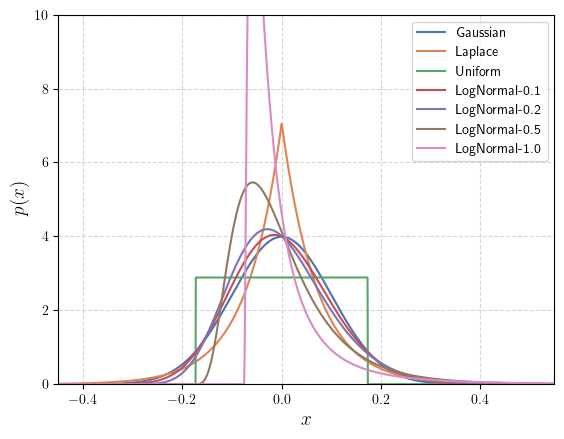

In [12]:
ax = sns.lineplot(df, x="x", y="pdf", hue="distribution", palette="deep")

ax.set_ylim(0, 10)
ax.set_xlim(-0.45, 0.55)

ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$p(x)$", fontsize=14)
# ax.set_title(r"Various noise distributions for observations")
ax.grid(linestyle="--", alpha=0.5)

ax.legend()


plt.savefig("../figs/various_noise_pdf.pdf")